In [1]:
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
plt.style.use('seaborn-colorblind')  
%matplotlib inline

In [2]:
#portfolio of the S&P 500, Total Bond Market Index and Gold
tickers = ['SPY','BND', 'GLD']

In [3]:
start = dt.datetime(2015,1,1)
end = dt.datetime(2020,12,31)

In [4]:
data = pd.DataFrame(yf.download(tickers, start, end)['Close'])

[*********************100%***********************]  3 of 3 completed


In [5]:
data.shape

(1510, 3)

In [6]:
returns = data.pct_change()

In [7]:
returns

,BND,GLD,SPY
Date,,,
2015-01-02,NaN,NaN,NaN
2015-01-05,0.002904,0.015077,-0.018060
2015-01-06,0.002895,0.011399,-0.009419
2015-01-07,0.000602,-0.005891,0.012461
2015-01-08,-0.001563,-0.004209,0.017745
...,...,...,...
2020-12-23,-0.004419,0.006648,0.000899
2020-12-24,0.001707,0.003985,0.003890
2020-12-28,-0.000341,-0.003629,0.008591


In [8]:
def portfolio_annualized_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252 #252 trading days a year
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [9]:
def generate_random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weight_array = []
    for i in range(num_portfolios):
        # Randomly assign weights
        weights = np.random.random(len(tickers))
        # Convert the randomized weights (summing to 100)
        weights /= np.sum(weights)
        weight_array.append(weights)
        # calculate the standard deviation
        portfolio_std_dev, portfolio_return = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weight_array

In [10]:
returns = data.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 100000
risk_free_rate = 0.01627 #10 year Treasury yield on June 2, 2021

In [11]:
returns_corr=round((returns.corr()),2)

In [12]:
returns_corr

,BND,GLD,SPY
BND,1.00,0.33,0.02
GLD,0.33,1.00,-0.03
SPY,0.02,-0.03,1.00


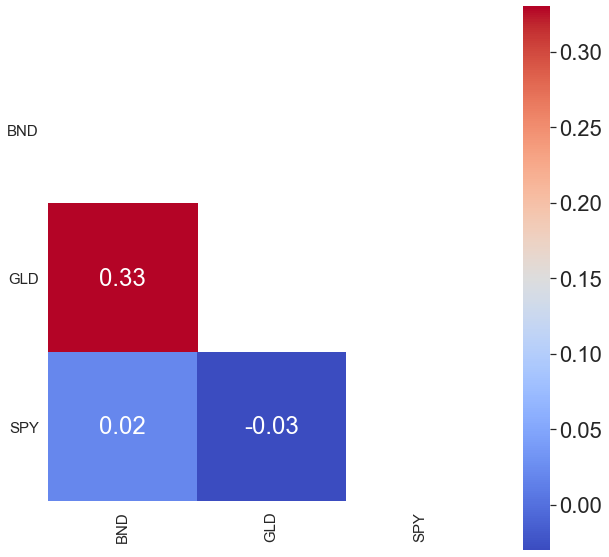

In [13]:
#correlation matrix
sns.set(style="white")
mask = np.zeros_like(returns_corr.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.subplots(figsize=(10,10))
sns.set(font_scale=2)
sns.heatmap(returns_corr, xticklabels=returns_corr.columns.values,
            yticklabels=returns_corr.columns.values,mask=mask, cmap = 'coolwarm', annot= True, square=True)
plt.yticks(rotation=0,fontsize = 15)
plt.xticks(rotation=90,fontsize = 15);

----------------------------------------------------------------------------------------------------
Portfolio at maximum Sharpe Ratio

--Returns, volatility--

Annualized Return: 0.1
Annualized Volatility: 0.11


--Allocation at max Sharpe ratio--

             BND    GLD    SPY
allocation  0.02  54.63  45.35
----------------------------------------------------------------------------------------------------


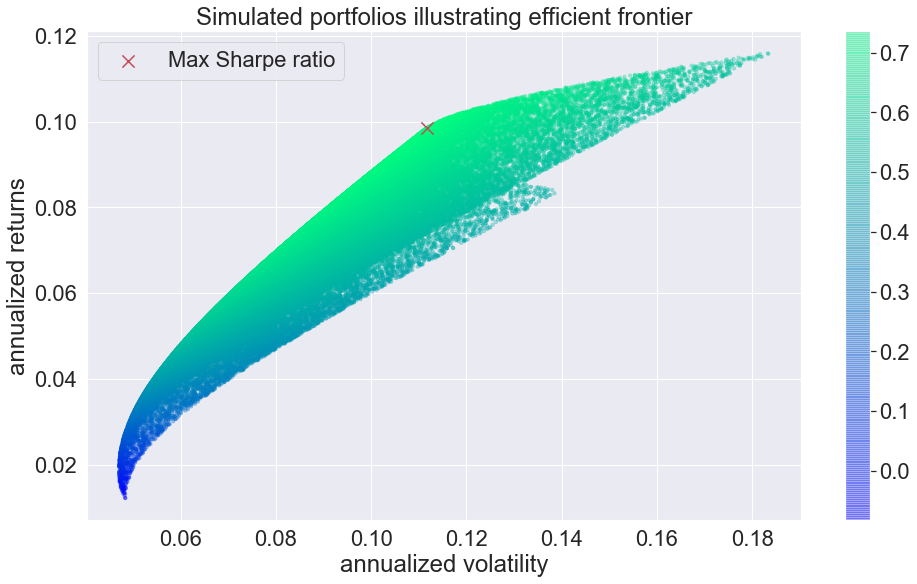

In [14]:
def display_simulated_portfolios(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = generate_random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    # max portfolio Sharpe ratio 
    max_sharpe_idx = np.argmax(results[2])

    # pull the associated standard deviation, annualized return w/ the max Sharpe ratio
    stdev_portfolio, returns_portfolio = results[0,max_sharpe_idx], results[1,max_sharpe_idx]

    # pull the allocation associated with max Sharpe ratio
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=data.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    print("-"*100)
    print("Portfolio at maximum Sharpe Ratio\n")
    print("--Returns, volatility--\n")
    print("Annualized Return:", round(returns_portfolio,2))
    print("Annualized Volatility:", round(stdev_portfolio,2))
    
    print("\n")
    print("--Allocation at max Sharpe ratio--\n")
    print(max_sharpe_allocation)
    print("-"*100)
    
    plt.figure(figsize=(16, 9))
    # x = volatility, y = annualized return, color mapping = sharpe ratio
    plt.scatter(results[0,:],results[1,:],c=results[2,:], cmap='winter', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    # Mark the portfolio w/ max Sharpe ratio
    plt.scatter(stdev_portfolio, returns_portfolio, marker='x',color='r',s=150, label='Max Sharpe ratio')
    plt.title('Simulated portfolios illustrating efficient frontier')
    plt.xlabel('annualized volatility')
    plt.ylabel('annualized returns')
    plt.legend(labelspacing=1.2)

display_simulated_portfolios(mean_returns, cov_matrix, num_portfolios, risk_free_rate)